In [45]:
# Relevant imports
import torch
import sys
import matplotlib.pyplot as plt
import numpy as np
from kan import KAN

# Set the seed for reproducibility
torch.manual_seed(42)

# Add the parent directory of the script (i.e., project/) to sys.path
sys.path.append('../../utils')
from upinn import UPINN
from architectures import FNN
from utils import RAD_sampler, sample_collocation_points
from NavierStokesData import NavierStokesData

In [46]:
# Data points
data = NavierStokesData(samplesize=5000)

In [47]:
# Collocation points
Xc = sample_collocation_points(5000, 3, [1, -2, 0], [8, 2, 20], method='sobol')

In [48]:
def compute_grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True, retain_graph=True)[0]

class NavierStokes(torch.nn.Module):
    def __init__(self, lambda1, lambda2):
        super(NavierStokes, self).__init__()
        self.lambda1 = lambda1
        self.lambda2 = lambda2


    def forward(self, Z, U):

        psi = U[:, 0:1]
        p = U[:, 1:2]

        U_z = compute_grad(psi, Z)

        psi_x = U_z[:, 0:1]
        psi_y = U_z[:, 1:2]

        u = psi_y
        v = -psi_x

        u_z = compute_grad(u, Z)
        u_x = u_z[:, 0:1]
        u_y = u_z[:, 1:2]
        u_t = u_z[:, 2:3]

        v_z = compute_grad(v, Z)
        v_x = v_z[:, 0:1]
        v_y = v_z[:, 1:2]
        v_t = v_z[:, 2:3]

        p_z = compute_grad(p, Z)
        p_x = p_z[:, 0:1]
        p_y = p_z[:, 1:2]

        u_xx = compute_grad(u_x, Z)[:, 0:1]
        u_yy = compute_grad(u_y, Z)[:, 1:2]

        v_xx = compute_grad(v_x, Z)[:, 0:1]
        v_yy = compute_grad(v_y, Z)[:, 1:2]

        f = u_t + self.lambda1 * (u * u_x + v * u_y) + p_x - self.lambda2 * (u_xx + u_yy)
        g = v_t + self.lambda1 * (u * v_x + v * v_y) + p_y - self.lambda2 * (v_xx + v_yy)

        return torch.cat([f, g], dim=1)

lambda1 = torch.nn.Parameter(torch.tensor(0.0))
lambda2 = torch.nn.Parameter(torch.tensor(0.0))

N = NavierStokes(lambda1, lambda2)

In [ ]:
class NavierStokesPINN(UPINN):
    

    def data_loss(self):

        if self.data_points is not None:
            
            self.data_points[0].requires_grad_(True)

            Ud = self.u(self.data_points[0])

            psi_z = compute_grad(Ud[:, 0], self.data_points[0])
            psi_y = psi_z[:, 1:2]
            psi_x = psi_z[:, 0:1]

            data_pred = torch.cat([psi_y, -psi_x], dim=1)
            data_loss = torch.mean((data_pred - self.data_points[1][:, 0:2])**2)

            self.log.setdefault("lambda1", []).append(lambda1.item())
            self.log.setdefault("lambda2", []).append(lambda2.item())

        else: data_loss = torch.tensor(0.0)

        return data_loss
    


In [50]:
hidden = [20] * 8

u = FNN(
    dims=[3, *hidden, 2],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)

In [ ]:
model = NavierStokesPINN(u, N, data_points=(data.Zd, data.Ud), collocation_points=Xc)

[Info]: Initializing PINN model (Residual network F unspecified; Setting F to 0.0)


In [52]:
adamw = torch.optim.AdamW(model.parameters(), lr=1e-3)
lbfgs = torch.optim.LBFGS(model.parameters(), lr=1)

In [53]:
model.optimizer = adamw
model.train_loop(1000)
model.optimizer = lbfgs
model.train_loop(500)

[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [01:09<00:00, 14.44 epoch/s, lambda1=5.39e-01, lambda2=1.11e-02, bc_loss=0.00e+00, data_loss=3.45e-02, pde_loss=2.22e-03, loss=3.67e-02]


[Info]: Training 500 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 500/500 [15:21<00:00,  1.84s/ epoch, lambda1=9.88e-01, lambda2=1.09e-02, bc_loss=0.00e+00, data_loss=5.64e-04, pde_loss=4.72e-04, loss=1.04e-03]


In [54]:
model.train_loop(500)

[Info]: Training 500 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 500/500 [14:15<00:00,  1.71s/ epoch, lambda1=9.96e-01, lambda2=1.07e-02, bc_loss=0.00e+00, data_loss=1.40e-04, pde_loss=1.56e-04, loss=2.96e-04]


In [57]:
model.train_loop(500)

[Info]: Training 500 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 500/500 [03:08<00:00,  2.66 epoch/s, lambda1=9.98e-01, lambda2=1.07e-02, bc_loss=0.00e+00, data_loss=4.40e-05, pde_loss=6.64e-05, loss=1.10e-04]


In [58]:
model.save('nv-pinn-reverse', 'models')

[Info]: Successfully saved total model with name nv-pinn-reverse at models


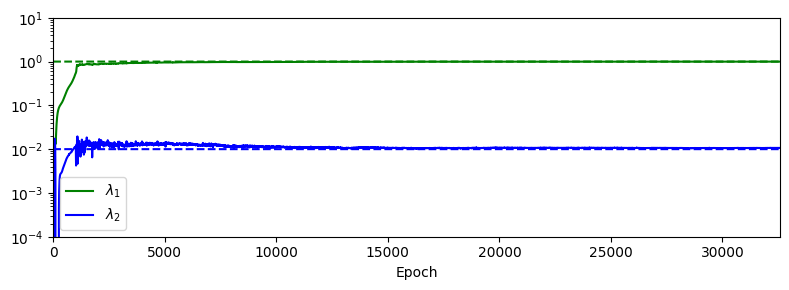

In [60]:
lam1 = model.log['lambda1']
lam2 = model.log['lambda2']

plt.figure( figsize=(8, 3) )
plt.plot(lam1, label=r'$\lambda_1$', color='green')
plt.plot(lam2, label=r'$\lambda_2$', color='blue')
plt.plot([1.0]*len(lam1), 'g--')
plt.plot([0.01]*len(lam2), 'b--')
plt.xlim(0, len(lam1))
plt.ylim(0.0001, 10)
plt.legend()
plt.yscale('log')
plt.xlabel('Epoch')
plt.tight_layout()
plt.savefig('gfx/nv-pinn-inverse-params.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [73]:
abs(u(data.Zd_full)[:, 0])

tensor([0.8352, 0.8292, 0.8235,  ..., 3.8951, 3.9147, 3.9351],
       grad_fn=<AbsBackward0>)

In [72]:
data.Ud_full[:, 2]

tensor([-0.1082, -0.1112, -0.1124,  ...,  0.0069,  0.0098,  0.0124])

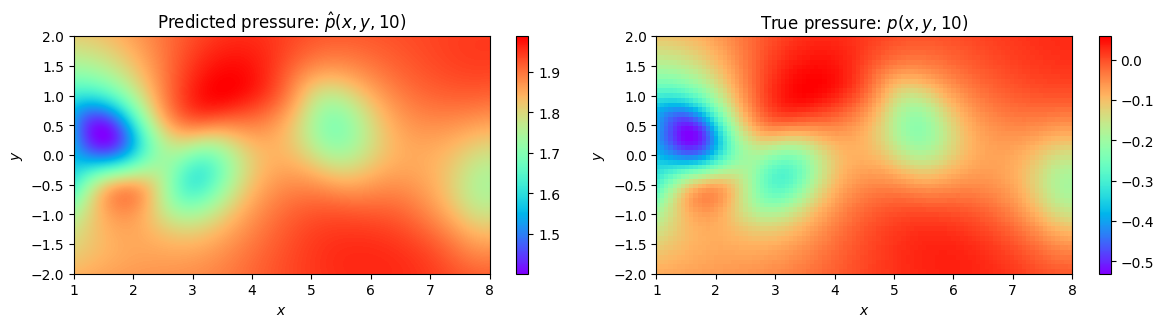

In [165]:
t = 10

# Predicted pressure at t
x = torch.linspace(1, 8, 1000)
y = torch.linspace(-2, 2, 1000)
X, Y = torch.meshgrid(x, y)
T = torch.ones_like(X) * t
Z = torch.stack([X, Y, T], dim=2).reshape(-1, 3)
U = u(Z)
U = U.detach().numpy().reshape(*X.shape, 2)
P_pred = U[..., 1].T

# True pressure at t
mask = data.Zd_full[:, 2] == t
P_true = data.Ud_full[:, 2][mask].reshape(50,100)

plt.subplots(1, 2, figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.imshow(P_pred, extent=(1, 8, -2, 2), cmap='rainbow', origin='lower')
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.xlim(1, 8)
plt.ylim(-2, 2)
# set equal aspect ratio
plt.gca().set_aspect('equal')
plt.title(r'Predicted pressure: $\hat{p}(x, y, 10)$')

plt.subplot(1, 2, 2)
plt.imshow(P_true, extent=(1, 8, -2, 2), cmap='rainbow', origin='lower')
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.xlim(1, 8)
plt.ylim(-2, 2)
# set equal aspect ratio
plt.gca().set_aspect('equal')
plt.title(r'True pressure: $p(x, y, 10)$')


plt.tight_layout()
plt.savefig('gfx/nv-pinn-inverse-pressure.pdf', format='pdf', bbox_inches='tight')
plt.show()






### Gags: Animate

In [ ]:
# Animation over time
import matplotlib.animation as animation

fig, ax = plt.subplots()

def animate(t):

    # Predicted pressure at t
    x = torch.linspace(1, 8, 1000)
    y = torch.linspace(-2, 2, 1000)
    X, Y = torch.meshgrid(x, y)
    T = torch.ones_like(X) * t
    Z = torch.stack([X, Y, T], dim=2).reshape(-1, 3)
    U = u(Z)
    U = U.detach().numpy().reshape(*X.shape, 2)
    P_pred = U[..., 1].T

    ax.clear()
    ax.imshow(P_pred, extent=(1, 8, -2, 2), cmap='rainbow', origin='lower')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_xlim(1, 8)
    ax.set_ylim(-2, 2)
    ax.set_aspect('equal')
    ax.set_title(r'Predicted pressure: $\hat{p}(x, y, %d)$' % t)

ani = animation.FuncAnimation(fig, animate, frames=np.linspace(0, 20, 200), interval=500, repeat=True)
ani.save('gfx/nv-pinn-inverse-pressure.gif', writer='pillow', fps=20)
plt.show()